In [118]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


"""
An `in-folder` reduction script CGM^2 Multi-Object Spectra

Note: You should really be running the prepare file to get this into the correct format...
"""

__author__ = "Matthew Wilde <mwilde@uw.edu>"
__version__ = "March 16, 2018"

try:
    from pyraf import iraf

except ImportError:
    raise ImportError("No pyraf module -- did you forget to do `source activate geminiconda`?")


import os
import copy
from pyraf.iraf import gemini, gmos, gemtools, onedspec
import numpy as np
from astropy.io import fits
from astropy.table import Table
import glob
import matplotlib.pyplot as plt
# from gmosutils import gmosutils
% matplotlib inline

path = os.path.abspath('.')

# Set colormap for plotting
cm = plt.get_cmap('Greys')

flatPrefix = 'MCflatCenSp_' 
# combName = 'MC' + 'gcalFlat' + 'Comb'
biasName = 'MCbiasCenSp.fits'


def observation_summary(filenames, additional_headers=None):
    """
    Create a table to serve as an observing summary.
    """
    
    # List the headers we want to extract
    headers = ["INSTRUME", "OBJECT", "OBSTYPE", "MASKNAME", "OBSCLASS", 
               "CENTWAVE", "GEMPRGID", "OBSID", "CCDBIN", "RAWPIREQ",
               "DATALAB", "UT", "DATE", "TIME-OBS", "GRATING", "EXPOSURE", "DETECTOR", "DATE-OBS"]
    
    if additional_headers is not None:
        headers += additional_headers

    rows = []
    for filename in filenames:
        with fits.open(filename) as image:
            rows.append(dict(zip(headers,
                [image[0].header.get(h, None) for h in headers])))

        # Add the filename.
        rows[-1]["FILENAME"] = filename

    headers.insert(0, "FILENAME")
    #headers.append("TIME")

    return Table(rows=rows, names=headers)

def show_img(img, z1, z2):
    plt.clf()
    ax = plt.gca()
    ax.imshow(img,vmin=z1,vmax=z2,cmap=cm, origin='lower')
    #
    plt.show()
    
def delete_inter_files():
    """Get rid of the intermediate gsreduced files iraf produces
    
    """
    intermediate_files = glob.glob('*gs*fits')
    for file in intermediate_files:
        try:
            os.remove(file)
        except OSError:
            pass
        
def delete_tmp_files():
    """Get rid of the intermediate gsreduced files iraf produces
    
    """
    intermediate_files = glob.glob('*tmp*')
    for file in intermediate_files:
        try:
            os.remove(file)
        except OSError:
            pass

def delete_sci_files():
    """Get rid of the intermediate gsreduced files iraf produces
    
    """
    intermediate_files = glob.glob('J*fits')
    for file in intermediate_files:
        try:
            os.remove(file)
        except OSError:
            pass

        
def delete_std_files():
    """Get rid of the intermediate gsreduced files iraf produces
    
    """
    intermediate_files = glob.glob('[W|E]*fits')
    for file in intermediate_files:
        try:
            os.remove(file)
        except OSError:
            pass
        

def get_CenSpbias():
    if not os.path.exists('MCbiasCenSp.fits'):
        print("No bias in this folder. copying from ../../../Bias/")
        from shutil import copyfile
        try:
            copyfile('../../../Bias/MCbiasFull.fits', './')
        except OSError:
            print('No bias? maybe need to make one')
            pass
    else:
        print("bias already exists, ready to roll!")

In [119]:
get_CenSpbias()
delete_tmp_files()
delete_inter_files()

raw_files = glob.glob('[N|S]*fits')
summary = observation_summary(raw_files)
cent_waves = list(set(summary[(summary['OBSTYPE'] == 'OBJECT')]['CENTWAVE']))

bias already exists, ready to roll!


# Flats

In [120]:
print ("### Begin Processing GMOS/MOS Spectra ###")
print (' ')
print('IN FOLDER: ',path)
print (' ')
print ("=== Creating FLAT MasterCals ===")
if not os.path.exists(flatPrefix+str(cent_waves[1])+'.fits'):
    print (" -- Creating GCAL Spectral Flat-Field MasterCals --")
    print ("  -CenSp Flat (GCAL) normalization, non-interactive-")

    # Set the task parameters.
    gmos.gireduce.unlearn()
    gmos.gsflat.unlearn()
    flatFlags = {'fl_over':'yes','fl_trim':'yes','fl_bias':'yes','fl_dark':'no',
                'fl_fixpix':'no','fl_oversize':'no','fl_vardq':'yes','fl_fulldq':'yes',
                'fl_inter':'no','fl_detec':'yes',
                'function':'spline3','order':'8',
                'logfile':'gsflatLog.txt','verbose':'no'
    }
    
    # TODO: make a case for LP data
    # flatFlags.update({'fl_keep':'yes','fl_usegrad':'yes','fl_detec':'no',
    #                 'fl_seprows':'no','order':53})
    
    
    # flat type
    ft = 'gcalFlat'
    # loop over central wavelengths
    flatName=''
    combName=''
    for cw in cent_waves:
        flatName = 'MCflatCenSp_'+(str(cw)[:-2])
        #flatName = 'MC' + ft + str(cw)
        flats = summary[(summary['OBSTYPE'] == 'FLAT') & (summary['CENTWAVE'] == cw)]['FILENAME']
        flatFull = [os.path.basename(f) for f in flats]
        gmos.gsflat (','.join(str(x) for x in flatFull), flatName, 
                     bias='MCbiasCenSp.fits', **flatFlags)
else:
    print('SKIPPING FLAT REDUX: '+flatPrefix+' already exists')

### Begin Processing GMOS/MOS Spectra ###
 
('IN FOLDER: ', '/Users/mwilde/Dropbox/COS-Gemini/gmosredux/standard/Wolf1346')
 
=== Creating FLAT MasterCals ===
 -- Creating GCAL Spectral Flat-Field MasterCals --
  -CenSp Flat (GCAL) normalization, non-interactive-
ERROR - GSFLAT: Output file MCflatCenSp_690 already exists.
ERROR - GSFLAT: 1 fatal errors found.
 
ERROR - GSFLAT: Program execution failed with 1 errors.
ERROR - GSFLAT: Output file MCflatCenSp_790 already exists.
ERROR - GSFLAT: 1 fatal errors found.
 
ERROR - GSFLAT: Program execution failed with 1 errors.
ERROR - GSFLAT: Output file MCflatCenSp_590 already exists.
ERROR - GSFLAT: 1 fatal errors found.
 
ERROR - GSFLAT: Program execution failed with 1 errors.


['MCflatCenSp_690.fits', 'MCflatCenSp_590.fits', 'MCflatCenSp_790.fits']
Filename: MCflatCenSp_690.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     251   ()      
  1  SCI           1 ImageHDU        71   (512, 512)   float32   
  2  SCI           2 ImageHDU        71   (512, 512)   float32   
  3  SCI           3 ImageHDU        71   (512, 512)   float32   
  4  SCI           4 ImageHDU        71   (512, 512)   float32   
  5  SCI           5 ImageHDU        71   (512, 512)   float32   
  6  SCI           6 ImageHDU        71   (512, 512)   float32   
  7  MDF           1 BinTableHDU     69   3R x 12C   [1J, 1E, 1E, 20A, 1J, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   
  8  VAR           1 ImageHDU        71   (512, 512)   float32   
  9  DQ            1 ImageHDU        35   (512, 512)   int16 (rescales to uint16)   
 10  VAR           2 ImageHDU        71   (512, 512)   float32   
 11  DQ            2 ImageHDU        35   (512, 512)   int16 (re

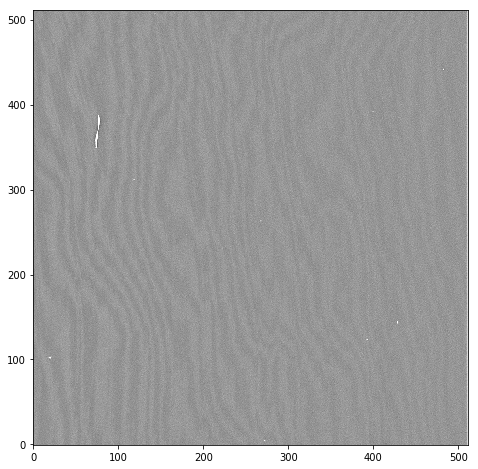

In [121]:
idx = 1
flats = glob.glob('MCflat*fits')
print(flats)
dfile = flats[0]
hdulist = fits.open(dfile)
hdulist.info()
data = hdulist[idx].data
header = hdulist[idx].header
data.shape
plt.figure(figsize=(8,8))
show_img(data, 0.8, 1.2)

In [122]:
delete_sci_files()

# Science and Arcs

In [123]:
get_CenSpbias()
delete_tmp_files()
delete_inter_files()
delete_std_files()

bias already exists, ready to roll!


In [138]:
! rm gs*fits

In [139]:

print ("=== Processing Science Files ===")
print (" -- Performing Basic Processing --")

# Use primarily the default task parameters.
gmos.gsreduce.unlearn()
sciFlags = {
    'fl_over':'yes','fl_trim':'yes','fl_bias':'yes','fl_gscrrej':'no',
    'fl_dark':'no','fl_flat':'yes','fl_gmosaic':'yes','fl_fixpix':'no',
    'fl_gsappwave':'yes','fl_oversize':'no',
    'fl_vardq':'yes','fl_fulldq':'yes',
    'fl_inter':'no','logfile':'gsreduceLog.txt','verbose':'no'
}

# Arc flags, no need to flat or dq
arcFlags = copy.deepcopy(sciFlags)
arcFlags.update({'fl_flat':'no','fl_vardq':'no','fl_fulldq':'no'})

# no need to dq, might as well fix the detector gaps
stdFlags = copy.deepcopy(sciFlags)
stdFlags.update({'fl_fixpix':'yes','fl_vardq':'no','fl_fulldq':'no', 'fl_gscrrej':'yes'})

gmos.gswavelength.unlearn()
waveFlags = {
    'coordlist':'gmos$data/CuAr_GMOS.dat','fwidth':6,'nsum':50,
    'function':'chebyshev','order':7,
    'fl_inter':'no','logfile':'gswaveLog.txt','verbose':'no'
    }
waveFlags.update({'order':7,'nsum':20,'step':2})


gmos.gstransform.unlearn()
transFlags = {
    'fl_vardq':'yes','interptype':'linear','fl_flux':'yes',
    'logfile':'gstransformLog.txt','verbose':'no'
}
   
print ('  - Long Slit Standard and Arc exposures -')
prefix = 'gs' # 
ft = 'gcalFlat' # flat type
for i,cw in enumerate(cent_waves):
    flatName = 'MCflatCenSp_'+(str(cw)[:-2])
    
    ################### ARCS: Reduce and find wavelengths ###############################
    # Arcs
    # arcFull = fs.fileListQuery(dbFile, fs.createQuery('arc', qdf), qdf)
    arcs = summary[(summary['OBSTYPE'] == 'ARC') & (summary['CENTWAVE'] == cw)]['FILENAME']
    arcFull = [os.path.basename(f) for f in arcs]
    reduced_arcs = [prefix + str(x) for x in arcFull]
    if not os.path.exists(reduced_arcs[0]):
        gmos.gsreduce (','.join(str(x) for x in arcFull), bias=biasName, **arcFlags)
        gmos.gswavelength(','.join(prefix+str(x) for x in arcFull), **waveFlags)
    
    ################### Standards: Reduce and find wavelengths ###############################
    # Standard Images
    sci = summary[(summary['OBSTYPE'] == 'OBJECT') & (summary['CENTWAVE'] == cw)]['FILENAME']
    sciFull = [os.path.basename(f) for f in sci]
    reduced_imgs = [prefix + str(x) for x in sciFull]
    
    # get the quasar name convention right: quasar+mask+centwave
    std_name = summary[(summary['OBSTYPE'] == 'OBJECT') & (summary['CENTWAVE'] == cw)]['OBJECT'][0]
    # maskname = summary[(summary['OBSTYPE'] == 'OBJECT') & (summary['CENTWAVE'] == cw)]['MASKNAME'][0][-2:]
    outFile = std_name+'_'+str(cw)[:-2]

    
    gmos.gsreduce.unlearn()
    
    

    # reduce the SCIENCE images
    if not os.path.exists(reduced_imgs[0]):
        gmos.gsreduce (','.join(str(x) for x in sciFull), bias=biasName, flatim=flatName, **stdFlags)
        # LP with 3 central wavelengths and 1 science exposure
    else:
        print("skipping gsreduce: file already exists "+reduced_imgs[0]+".fits")

    if not os.path.exists(outFile+".fits"):
        # transform the sci images
        gmos.gstransform (reduced_imgs[0], wavtraname='gs'+arcFull[0], outimages=outFile,
                      **transFlags)
    else:
        print("skipping gstransform: file already exists"+outFile+".fits")

=== Processing Science Files ===
 -- Performing Basic Processing --
  - Long Slit Standard and Arc exposures -


In [140]:
std_list = glob.glob('Wolf*fits')
glob.glob('Wolf*fits')

['Wolf1346_590.fits', 'Wolf1346_790.fits', 'Wolf1346_690.fits']

['MCflatCenSp_690.fits', 'MCflatCenSp_590.fits', 'MCflatCenSp_790.fits']
Filename: Wolf1346_590.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     215   ()      
  1  MDF           1 BinTableHDU     69   3R x 12C   [1J, 1E, 1E, 20A, 1J, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   
  2  SCI           1 ImageHDU       107   (3108, 512)   float32   


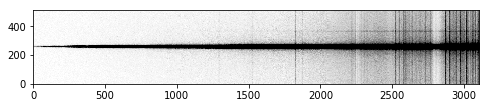

In [142]:
idx = 2
sky_stds = glob.glob('Wolf*fits')
print(flats)
dfile = sky_stds[0]
hdulist = fits.open(dfile)
hdulist.info()
data = hdulist[idx].data
header = hdulist[idx].header
data.shape
plt.figure(figsize=(8,8))
show_img(data, 0, 100)

In [143]:
! rm sWolf*fits
gmos.gsskysub.unlearn()
skyFlags = {
    'fl_oversize':'no','fl_vardq':'no','logfile':'gsskysubLog.txt',
    'verbose':'no'
}
gmos.gsskysub ('Wolf*', long_sample='50:150,400:500', **skyFlags)

rm: sWolf*fits: No such file or directory


In [144]:
glob.glob('*fits')

['sWolf1346_590.fits',
 'gN20150516S0234.fits',
 'Wolf1346_590.fits',
 'N20150516S0234.fits',
 'N20150516S0235.fits',
 'gN20150516S0235.fits',
 'gsN20150516S0236.fits',
 'Wolf1346_790.fits',
 'sWolf1346_790.fits',
 'N20150516S0232.fits',
 'gsN20150516S0266.fits',
 'gN20150516S0232.fits',
 'gN20150516S0233.fits',
 'gsN20150516S0267.fits',
 'N20150516S0268.fits',
 'gN20150516S0268.fits',
 'MCflatCenSp_690.fits',
 'N20150516S0233.fits',
 'MCbiasCenSp.fits',
 'gsN20150516S0268.fits',
 'N20150516S0267.fits',
 'gN20150516S0267.fits',
 'Wolf1346_690.fits',
 'sWolf1346_690.fits',
 'gsN20150516S0232.fits',
 'gN20150516S0266.fits',
 'N20150516S0266.fits',
 'gN20150516S0236.fits',
 'gsN20150516S0235.fits',
 'N20150516S0236.fits',
 'MCflatCenSp_590.fits',
 'N20150516S0237.fits',
 'MCflatCenSp_790.fits',
 'gN20150516S0237.fits']

['sWolf1346_590.fits', 'sWolf1346_790.fits', 'sWolf1346_690.fits']
Filename: sWolf1346_690.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     215   ()      
  1  MDF           1 BinTableHDU     69   3R x 12C   [1J, 1E, 1E, 20A, 1J, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   
  2  SCI           1 ImageHDU       107   (3108, 512)   float32   


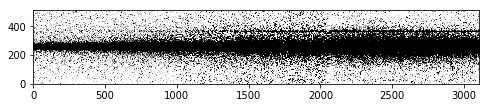

In [145]:
idx = 2
sky_stds = glob.glob('sWolf*fits')
print(sky_stds)
dfile = sky_stds[2]
hdulist = fits.open(dfile)
hdulist.info()
data = hdulist[idx].data
header = hdulist[idx].header
data.shape
plt.figure(figsize=(8,8))
show_img(data, 0.8, 10)

In [146]:
gmos.gsextract.unlearn()
extrFlags = {
    'apwidth':6.,'fl_inter':'yes','find':'yes',
    'trace':'yes','tfunction':'spline3','tnsum':20,'tstep':50,
    'weights':'none','background':'none',
    'fl_vardq':'no','verbose':'no','logfile':'gsextractLog.txt'
}
# ordc = {'B6-420':7, 'B6-520':8, 'B6-620':8, 'R4-620':19, 'R4-740':19}
sky_stds = glob.glob('sWolf*fits')
for inFile in sky_stds:
    gmos.gsextract (inFile, torder=6, **extrFlags)

Recenter apertures for sWolf1346_590[SCI,1]?Edit apertures for sWolf1346_590[SCI,1]?

     aperture = 1  beam = 1  center = 259.28  low = -20.58  upper = 20.58


Trace apertures for sWolf1346_590[SCI,1]?Fit traced positions for sWolf1346_590[SCI,1] interactively?Fit curve to aperture 1 of sWolf1346_590[SCI,1] interactivelyWrite apertures for sWolf1346_590[SCI,1] to databaseExtract aperture spectra for sWolf1346_590[SCI,1]?Review extracted spectra from sWolf1346_590[SCI,1]?Review extracted spectrum for aperture 1 from sWolf1346_590[SCI,1]?Recenter apertures for sWolf1346_790[SCI,1]?Edit apertures for sWolf1346_790[SCI,1]?

     aperture = 1  beam = 1  center = 258.94  low = -29.58  upper = 26.29


Trace apertures for sWolf1346_790[SCI,1]?Fit traced positions for sWolf1346_790[SCI,1] interactively?Fit curve to aperture 1 of sWolf1346_790[SCI,1] interactivelyWrite apertures for sWolf1346_790[SCI,1] to databaseExtract aperture spectra for sWolf1346_790[SCI,1]?Review extracted spectra from sWolf1346_790[SCI,1]?Review extracted spectrum for aperture 1 from sWolf1346_790[SCI,1]?Recenter apertures for sWolf1346_690[SCI,1]?Edit apertures for sWolf1346_690[SCI,1]?

     aperture = 1  beam = 1  center = 258.87  low = -20.58  upper = 20.58
     aperture = 1  beam = 1  center = 258.87  low = -31.40  upper = 20.58
Invalid or unrecognized command     aperture = 1  beam = 1  center = 258.87  low = -31.40  upper = 20.58
     aperture = 1  beam = 1  center = 258.87  low = -31.40  upper = 20.58


Review extracted spectrum for aperture 1 from sWolf1346_690[SCI,1]?

     aperture = 1  beam = 1  center = 258.87  low = -31.40  upper = 20.58


Fit curve to aperture 1 of sWolf1346_690[SCI,1] interactively

     aperture = 1  beam = 1  center = 258.88  low = -31.40  upper = 20.58


Trace apertures for sWolf1346_690[SCI,1]?Fit traced positions for sWolf1346_690[SCI,1] interactively?Fit curve to aperture 1 of sWolf1346_690[SCI,1] interactivelyWrite apertures for sWolf1346_690[SCI,1] to databaseExtract aperture spectra for sWolf1346_690[SCI,1]?Review extracted spectra from sWolf1346_690[SCI,1]?Review extracted spectrum for aperture 1 from sWolf1346_690[SCI,1]?

In [147]:
# glob.glob('esWolf*')
idx = 2
stds = glob.glob('esWolf*fits')
print(stds)
dfile = stds[0]
hdulist = fits.open(dfile)
hdulist.info()
data = hdulist[idx].data
header = hdulist[idx].header

['esWolf1346_690.fits', 'esWolf1346_590.fits', 'esWolf1346_790.fits']
Filename: esWolf1346_690.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     215   ()      
  1  MDF           1 BinTableHDU     69   3R x 12C   [1J, 1E, 1E, 20A, 1J, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   
  2  SCI           1 ImageHDU        71   (3108,)   float32   


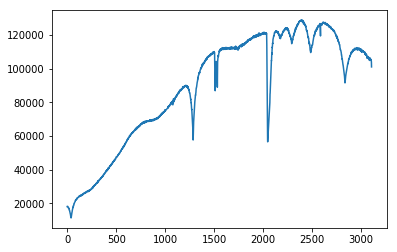

In [148]:
plt.plot(data)

In [161]:
gmos.gsstandard.unlearn()
sensFlags = {
    'fl_inter':'yes','starname':'wolf1346','caldir':'onedstds$spec50cal/',
    'observatory':'Gemini-North','extinction':'./mk_extinct.txt',
    'function':'spline3','order':7,'verbose':'no','logfile':'gsstdLog.txt'
}

for cw in cent_waves:
    cw = str(cw)[:-2]
    gmos.gsstandard ('esWolf1346_'+cw+'.fits', sfile='std_Wolf1346_'+cw+'.fits', sfunction='sens_Wolf1346_'+cw+'.fits',
                 **sensFlags)

--------------------------------------------------------------------------------
GSSTANDARD -- Thu Mar 29 18:41:40 PDT 2018


stdmag[i]=-99.0esWolf1346_690.fits[SCI,1](1): Wolf1346
esWolf1346_690.fits[SCI,1][1]: Edit bandpasses? window:Fit aperture 1 interactively? Sensitivity function for all apertures --> sens_Wolf1346_690.fits
GSSTANDARD done. Exit status good -- Thu Mar 29 18:41:50 PDT 2018

--------------------------------------------------------------------------------
GSSTANDARD -- Thu Mar 29 18:41:50 PDT 2018


stdmag[i]=-99.0esWolf1346_790.fits[SCI,1](1): Wolf1346
esWolf1346_790.fits[SCI,1][1]: Edit bandpasses? Fit aperture 1 interactively? esWolf1346_790.fits[SCI,1] - Delete p(oint), s(tar), or w(avelength):
esWolf1346_790.fits[SCI,1] - Delete p(oint), s(tar), or w(avelength):
esWolf1346_790.fits[SCI,1] - Delete p(oint), s(tar), or w(avelength):
esWolf1346_790.fits[SCI,1] - Delete p(oint), s(tar), or w(avelength):
esWolf1346_790.fits[SCI,1] - Delete p(oint), s(tar), or w(av